# Algoritmos de clasificación - Naïve Bayes

**Nombre alumno: Juan Pablo Ramírez**

Profesor: Heriberto Briceño - Gonzalo Seguel.

Generación: **G-16**

### Solución Desafío - Naive Bayes

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

### Descripción

* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. 
* Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto. Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a patir de la letra de una canción.
* Existen 4 géneros que se registran en la base de datos, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

### Ejercicio 1: Preparar el ambiente de trabajo

* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump.
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [38]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import missingno as msno
import glob
import os

# Métodos asociados a regularización
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Especificaciones
warnings.filterwarnings(action= 'ignore')
plt.style.use('seaborn-whitegrid')

# Funciones propias
from d3_funciones import *

In [2]:
route = os.getcwd()
route

'C:\\Users\\USER\\Dropbox\\Desafio_Latam\\Machine Learning\\Desafio 3'

In [3]:
def load_data(path):
    '''
    carga el dataset
    '''
    # Definiendo la carga de todos los datos 
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        file = pd.read_csv(filename, index_col=None, header=0)
        li.append(file)
    data = pd.concat(li, axis=0, ignore_index=True)
    return data

In [4]:
df_lyrics = load_data(f'{route}/dump')
df = df_lyrics.drop('Unnamed: 0', axis=1)

In [5]:
df.info

<bound method DataFrame.info of             0      1                                    2  \
0     Anthrax  metal                           Deathrider   
1     Anthrax  metal                  Metal Thrashing Mad   
2     Anthrax  metal                         I'm Eighteen   
3     Anthrax  metal                                Panic   
4     Anthrax  metal                           Subjugator   
...       ...    ...                                  ...   
9484   Weezer   rock  Thief, You've Taken All That Was Me   
9485   Weezer   rock                   We Are All In Love   
9486   Weezer   rock                       We Go Together   
9487   Weezer   rock                 What Is This I Find?   
9488   Weezer   rock                             Zep Jamb   

                                                      3  
0     Riding hard, high in the saddle \n Winged stee...  
1     Racing down the road \n In a street machine of...  
2     Lines form on my face and hands \n Lines form ...  
3  

In [6]:
df.sample()

,0,1,2,3
5817,Nickelback,rock,Miss You,"(I miss you so, so I do... I miss you so, so I..."


### Ejercicio 2: Descripción de los datos
* Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    * La cantidad de canciones registradas por cada artista, ordenado de mayor a menor.
    * La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
* Comente sobre las principales tendencias.

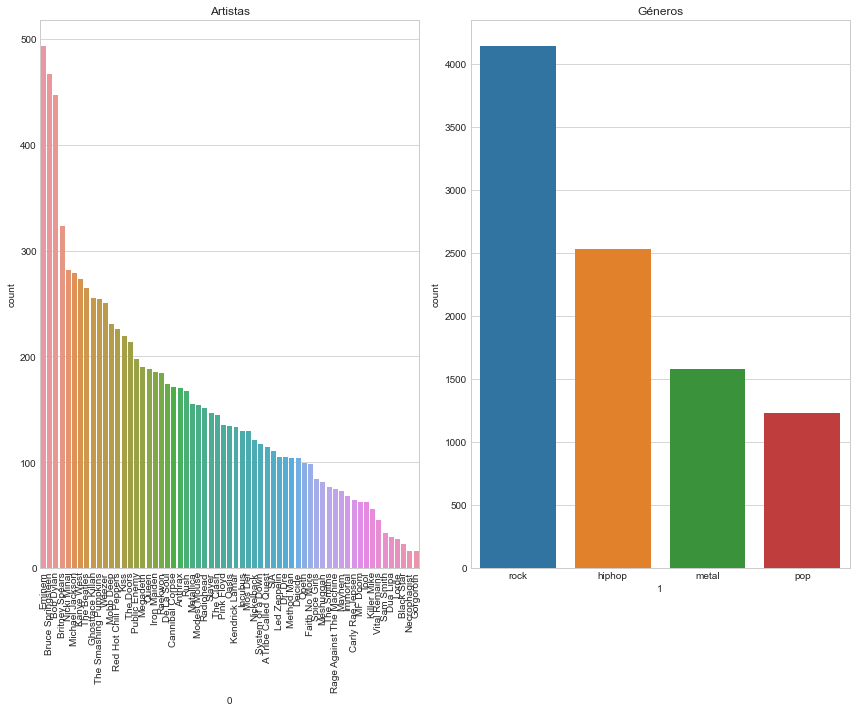

In [7]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
sns.countplot(df['0'], order=df['0'].value_counts().index)
plt.xticks(rotation=90);
plt.title('Artistas')
plt.subplot(1,2,2)
sns.countplot(df['1'], order=df['1'].value_counts().index)
plt.title('Géneros')
plt.tight_layout()

In [8]:
df['0'].value_counts('%')

Eminem               0.051955
Bruce Springsteen    0.049215
Bob Dylan            0.047107
Britney Spears       0.034039
Nicki Minaj          0.029719
                       ...   
Dua Lipa             0.003056
Lorde                0.002845
Black Star           0.002424
Necrophagist         0.001686
Gorgoroth            0.001686
Name: 0, Length: 61, dtype: float64

In [9]:
df['1'].value_counts('%')

rock      0.436295
hiphop    0.267151
metal     0.166719
pop       0.129835
Name: 1, dtype: float64

#### Comentarios:
La base de datos está compuesta por un total de 9489 canciones, correspondientes a un total de 61 artistas. De ellas, los artistas mayormente representados son Eminem, Bruce Springsteen y Bob Dylan, en donde el 5% del total de canciones cada uno. Por otra parte, el género más representado es el rock (44%), seguido del hiphop(27%), metal(17%) y pop (13%).

### Ejercicio 3: Matriz de ocurrencias

* Digresión: Tokenización de Textos
    * Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila representará una entrada (en este caso, una canción), y cada columna representará una palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra específica dentro de un conjunto de textos (corpus). El tokenizador más simple sklearn.feature_extraction.text.CountVectorizer genera una colección de textos a una matriz que representa la frecuencia dentro del texto de una palabra específica. El tokenizador funciona de la siguiente manera:
    
```python

from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
```

##### Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn . Lea la documentación asociada a ésta. ¿Cuál es el objetivo de esta clase?

CountVectorizer transforma un grupo (colección) de texto, realizando una matriz conteo de tokens (palabras).

##### Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos.

* Genere una función que replique el procedimiento para cada uno de los géneros.

#### - 100 palabras de canciones más frecuentes entre todos los géneros

In [10]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer_fit = count_vectorizer.fit_transform(df['3'])
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

(      Palabras  Conteo palabras
 0         like            19629
 1          don            17398
 2         know            14962
 3          got            14171
 4         just            13978
 ...        ...              ...
 49014   kidman                1
 49015    kiddo                1
 49016   kidder                1
 49017   kiddap                1
 49018   ﬁnally                1
 
 [49019 rows x 2 columns], None)

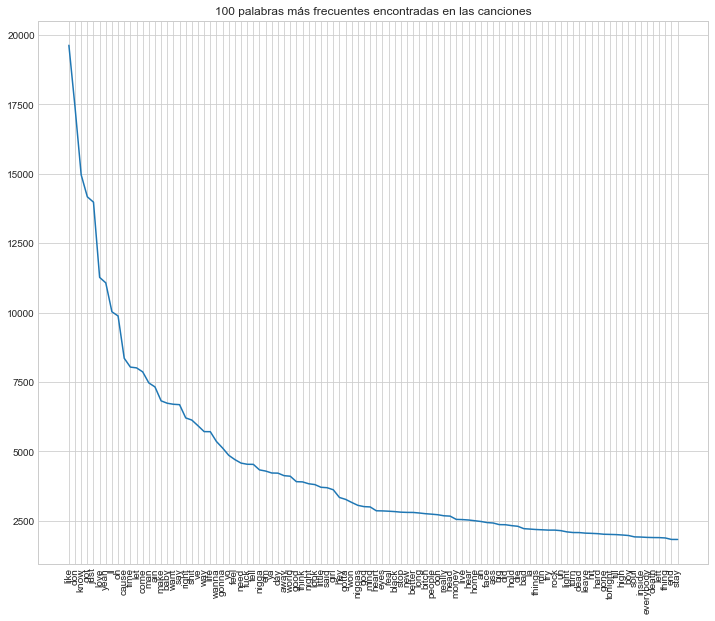

In [11]:
palabras_frecuentes(words, words_freq, 100)

#### - 100 palabras de canciones más frecuentes desglozadas por género

In [12]:
estilos = df['1'].unique()

##### Metal

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

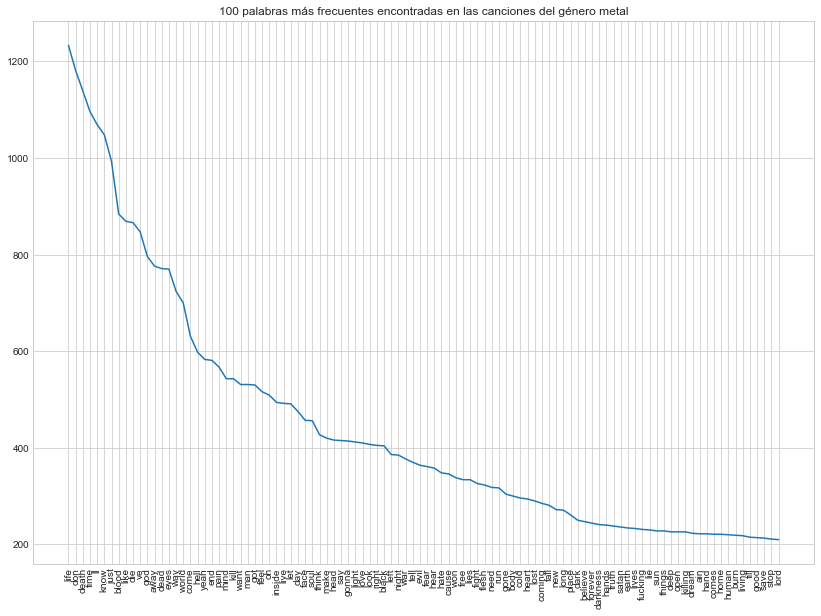

In [13]:
palabras_estilo_frecuencia(df, '1', estilos[0], '3', 100);
plt.tight_layout

##### Hip-hop

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

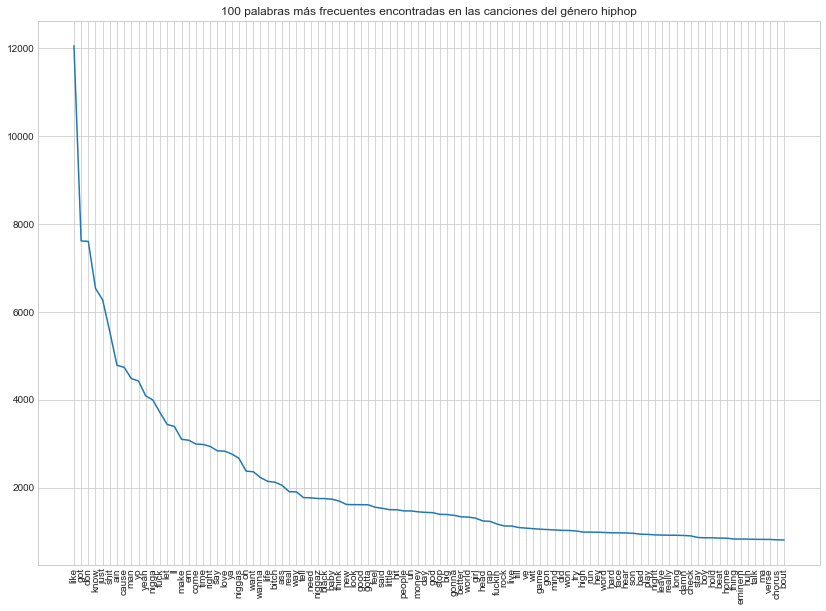

In [14]:
palabras_estilo_frecuencia(df, '1', estilos[1], '3', 100);
plt.tight_layout

##### Rock

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

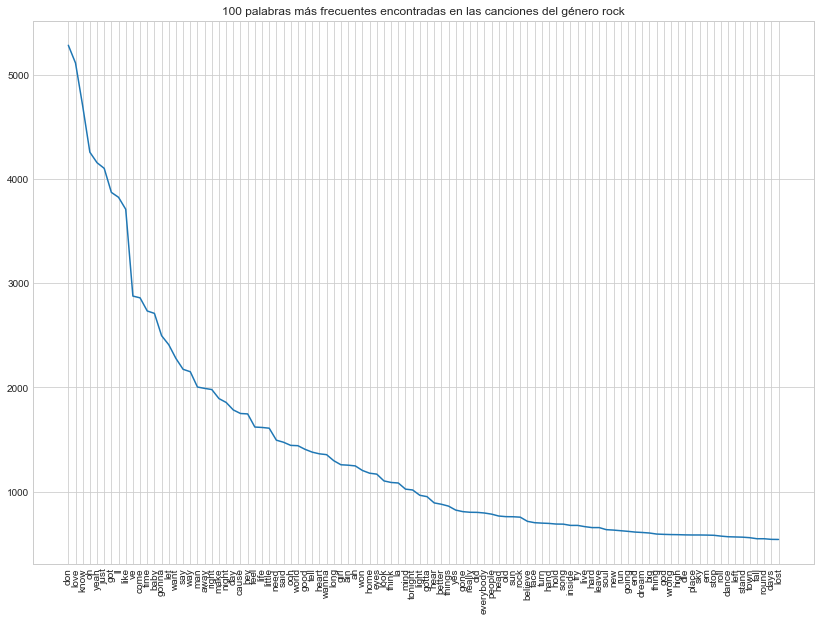

In [15]:
palabras_estilo_frecuencia(df, '1', estilos[2], '3', 100);
plt.tight_layout

##### Pop

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

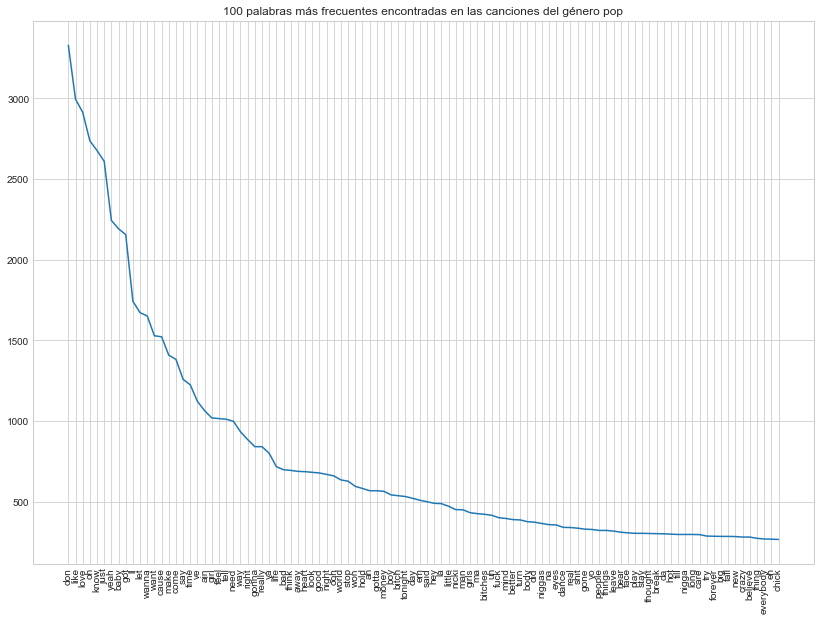

In [16]:
palabras_estilo_frecuencia(df, '1', estilos[3], '3', 100);
plt.tight_layout

* Comente sobre las principales características de cada género en cuanto a sus palabras.

Dentro de las 100 palabras más utilizadas, las 5 primeras mayorías corresponden a las palabras like, don, know, got y just. La pendiente de caida entre estas 5 palabras es significativamente pronunciada, con diferencis entre puntos que van desde las 1000 a 3000 palabras.

En cuanto a cada género, las 5 palabras más frecuentes dentro de las listas generadas fueron las siguientes:
a) Metal: Life, don, death, time, ll. En este género se aprecia que la pendiente de caida entre las primeras 5 palabras es menos pronunciada a lo visto en géneros como el Hip-hop, con frecuencias cercanas que varian en el orden de las 100 palabras.

b) Hip-hop: Like, got, don, know, just. A diferencia del género anterior, se aprecia que la pendiente generada por la curva de las 5 palabras más frecuentes, es significativamente más pronunciada (tendencia a cero) que en los otros géneros, con frecuencias que varian en el orden de las 1000 a 4000 palabras.

c) Rock: Don, love, know, oh, yeah. Las dos primeras palabras presentan una frecuencia similar entre sí, lo cual comienza a hacerse significativamente mayor desde la tercera palabra. La pendiente de caida presenta es significativamente mayor a lo visto en el hip-hop y menor respecto al metal.

d) Pop: Don, like, love, oh, know. La diferencia entre las 5 primeras mayorías tiende a diferir en el orden de las 200 a 250 palabras, siendo el género con mayor homogeneidad en el uso de estas. La pendiente de decaimiento tiende a ser menos pronunciada a lo observado en el género metal.

En cuanto al uso de palabras, es posible apreciar que en los géneros metal, pop y rock, la tendencia a la homogeneidad de las frecuencias revela que estas letras tienden a tener una mayor riqueza léxica que en el hip-hop. Por otro lado, la alta frecuencia de la palabra like en el hip-hop (60% respecto del total de palabras usadas por todos los géneros) puede explicarse a que gran parte de las letras tienden al establecimientos de frases de tipo comparativo; aspecto que caracteriza a este género.

Finalmente, las palabras don (4/4 géneros) y know (3/4 géneros) son las más conservadas entre géneros. Probablemente, esto se deba a que tiendan a utilizarse juntas en frases como "don't know" o similares.

### Ejercicio 4: Entrenamiento del Modelo
* Digresión: sklearn Pipelines
    * La clase Pipeline del módulo sklearn.pipeline permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikitlearn . En sí, la clase cuenta con los métodos clásicos fit , predict y score y presenta un comportamiento idéntico a los demás objetos de scikit-learn . Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo.
    
* Componentes de un Pipeline
   * Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo Estandarlizarlo, posteriormente extraer sus principales componentes y finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:
       
```python
pipeline_model = Pipeline([('scale', StandardScaler()),
                            ('pca', RandomizedPCA(n_components=3)),
                            ('model', LinearRegression())])
```
Algunos de los elementos a considerar:
1. Cada paso se considera como una tupla, donde se declara el nombre del paso y la función
a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que
asociamos el método StandardScaler con el string scale .
2. Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso
representa el orden de ejecución.
Posteriormente el objeto creado puede utilizarse con los siguientes métodos

```python
pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(y_test)
```

* Importe MultinomialNB , train_test_split , Pipeline , confusion_matrix y classification_report.
* Genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria.
* Monte el modelo dentro de un Pipeline , donde el primer paso es implementar CountVectorizer y el segundo sea ejecutar el clasificador MultinomialNB.
* A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones correspondientes?

```python
['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]
```

* Genere una predicción implementando la muestra de validación y contraste las predicciones del modelo con las etiquetas verdaderas. Reporte las principales métricas.

In [17]:
X= df['3']

In [18]:
y = df['1']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state= 20000)

In [20]:
pipeline_model = Pipeline([('count_vectorizer', CountVectorizer(stop_words='english')),('model', MultinomialNB())]).fit(X_train, y_train)

In [21]:
nb_class_pred = pipeline_model.predict(X_test)
print(classification_report(y_test, nb_class_pred))

              precision    recall  f1-score   support

      hiphop       0.85      0.92      0.89      1024
       metal       0.84      0.69      0.76       618
         pop       0.69      0.38      0.49       518
        rock       0.75      0.87      0.80      1636

    accuracy                           0.79      3796
   macro avg       0.78      0.72      0.73      3796
weighted avg       0.78      0.79      0.78      3796



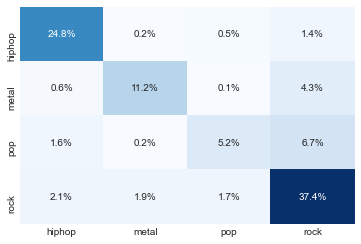

In [22]:
cnf = confusion_matrix(y_test, nb_class_pred)/len(y_test)
target_label = pipeline_model.classes_
sns.heatmap(cnf, annot=True, fmt='.1%', cbar=False, cmap='Blues', xticklabels=target_label, yticklabels=target_label)

#### Prueba de modelo

In [23]:
entrenamiento = ['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates', # IDLES - Mother
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]

In [24]:
y_predicted = pipeline_model.predict(entrenamiento)
pd.DataFrame({'Autor': ['Brody Dalle', 'Gorguts', 'N\'SYNC', 'Ludacris', 'IDLES', 'Banks'],
              'Canción': ['Underworld', 'Forgotten Arrows', 'Bye Bye Bye', 'Move B*tch', 'Mother', 'Drowning'],
              'Género reconocido': ['Rock (alternativo)', 'Metal (Death)', 'Pop', 'Hip-hop', 'Rock (Punk)', 'Pop (Electropop)'],
              'Género predicho': y_predicted})

,Autor,Canción,Género reconocido,Género predicho
0,Brody Dalle,Underworld,Rock (alternativo),rock
1,Gorguts,Forgotten Arrows,Metal (Death),metal
2,N'SYNC,Bye Bye Bye,Pop,rock
3,Ludacris,Move B*tch,Hip-hop,pop
4,IDLES,Mother,Rock (Punk),metal
5,Banks,Drowning,Pop (Electropop),rock


### Ejercicio 5: Mejora del Modelo
* Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
* Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
* Comente sobre el desempeño general de éste.

In [40]:
vec = TfidfVectorizer()

In [46]:
X_vec = vec.fit_transform(X_train)
y_vec = vec.fit_transform(y_train)

In [57]:
X_vec, y_vec

(<5693x38897 sparse matrix of type '<class 'numpy.float64'>'
 	with 758459 stored elements in Compressed Sparse Row format>,
 <5693x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 5693 stored elements in Compressed Sparse Row format>)

In [51]:
sm = SMOTE(random_state = 20000, sampling_strategy='minority') 
X_train_res, y_train_res = sm.fit_sample(X_vec, y_vec)

In [53]:
nb_classifier = MultinomialNB().fit(X_train_res, y_train_res)

ValueError: y should be a 1d array, got an array of shape (7483, 4) instead.